In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

from sklearn import metrics

## 1. Inspection

In [146]:
df=pd.read_csv("mushrooms.csv")

In [147]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


An 8124 by 23 column array

In [148]:
#View data head
df.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


As described in task columns have been annotated with labels

<AxesSubplot:>

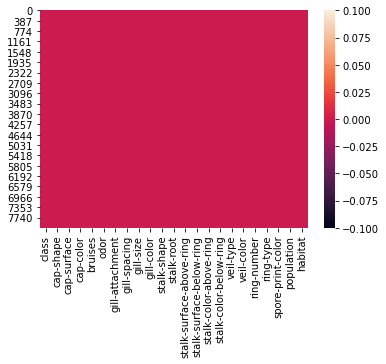

In [149]:
#Next we check for nulls
sns.heatmap(df.isnull())

Seems there are no nulls in the data

In [150]:
#Explore column labels and counts
col_counts=[]
for column in df.columns:
    col_counts.append({'Col_name':column,
                      'Values':df[column].value_counts()})

In [151]:
print(col_counts)

[{'Col_name': 'class', 'Values': e    4208
p    3916
Name: class, dtype: int64}, {'Col_name': 'cap-shape', 'Values': x    3656
f    3152
k     828
b     452
s      32
c       4
Name: cap-shape, dtype: int64}, {'Col_name': 'cap-surface', 'Values': y    3244
s    2556
f    2320
g       4
Name: cap-surface, dtype: int64}, {'Col_name': 'cap-color', 'Values': n    2284
g    1840
e    1500
y    1072
w    1040
b     168
p     144
c      44
u      16
r      16
Name: cap-color, dtype: int64}, {'Col_name': 'bruises', 'Values': f    4748
t    3376
Name: bruises, dtype: int64}, {'Col_name': 'odor', 'Values': n    3528
f    2160
s     576
y     576
a     400
l     400
p     256
c     192
m      36
Name: odor, dtype: int64}, {'Col_name': 'gill-attachment', 'Values': f    7914
a     210
Name: gill-attachment, dtype: int64}, {'Col_name': 'gill-spacing', 'Values': c    6812
w    1312
Name: gill-spacing, dtype: int64}, {'Col_name': 'gill-size', 'Values': b    5612
n    2512
Name: gill-size, dtype: int64

It appears the output class is quite evenly distributed therefore random sampling should work.
Since feature classes are distributed unevenly it is likely that few labels dictate the classification, this will be explored when evaluating results.
Also note that stalk root has a label tagged 'missing- ?' this is problematic since nearly 1/4 of the data has missing root information, and cannot be excluded. 

Dropping rows or columns does not work here, since 1/4 of the data or a possibly useful dimansion is lost. Therefore we look to impute these values.

## 2. Adjustments

<b> KNN- Imputation </b> (Imputing means and medians works for a small number of samples since this is much larger the values should be imputed on neighbor proximity based on all other dimensions except class)

In [152]:
#Create a copy and add the column back to the original data
df1=df.copy()
df1.drop(columns='class',inplace=True)

Ordinal transform for KNN imputation:

In [153]:
#Replace missing values with nulls
df1['stalk-root']=df1['stalk-root'].replace('?',np.nan)

#Convert everything except stalk- root to ordinal
ordinal=OrdinalEncoder()
#apply ordinal transformation
non_prob_cols=df1.drop(columns=['stalk-root']).columns.to_list()
df1[non_prob_cols]=ordinal.fit_transform(df1[non_prob_cols])

#Ordinal transformation of column with missing values
df1['stalk-root'].loc[df1['stalk-root'].notnull()]=np.squeeze(ordinal.fit_transform(np.array(df1['stalk-root']
                                                                     .dropna())
                                                                     .reshape(-1,1)))

Imputation Step:

In [154]:
imputer=KNNImputer()
df1=pd.DataFrame(np.round(imputer.fit_transform(df1)),columns=df1.columns)
df1['stalk-root']=np.squeeze(ordinal.inverse_transform(np.array(df1['stalk-root']).reshape(-1,1)))

Substitute back to Original data:

In [155]:
#Verify everything apart from the imputed values is identical for the column 
pd.Series(df['stalk-root'].loc[df['stalk-root']!='?']==df1['stalk-root'].loc[df['stalk-root']!='?']).unique()

array([ True])

In [156]:
#Substitute
df['stalk-root']=df1['stalk-root']

## 3. Exploratory Data Analysis

In [157]:
to_plot=df.drop(columns='class').columns.to_list()

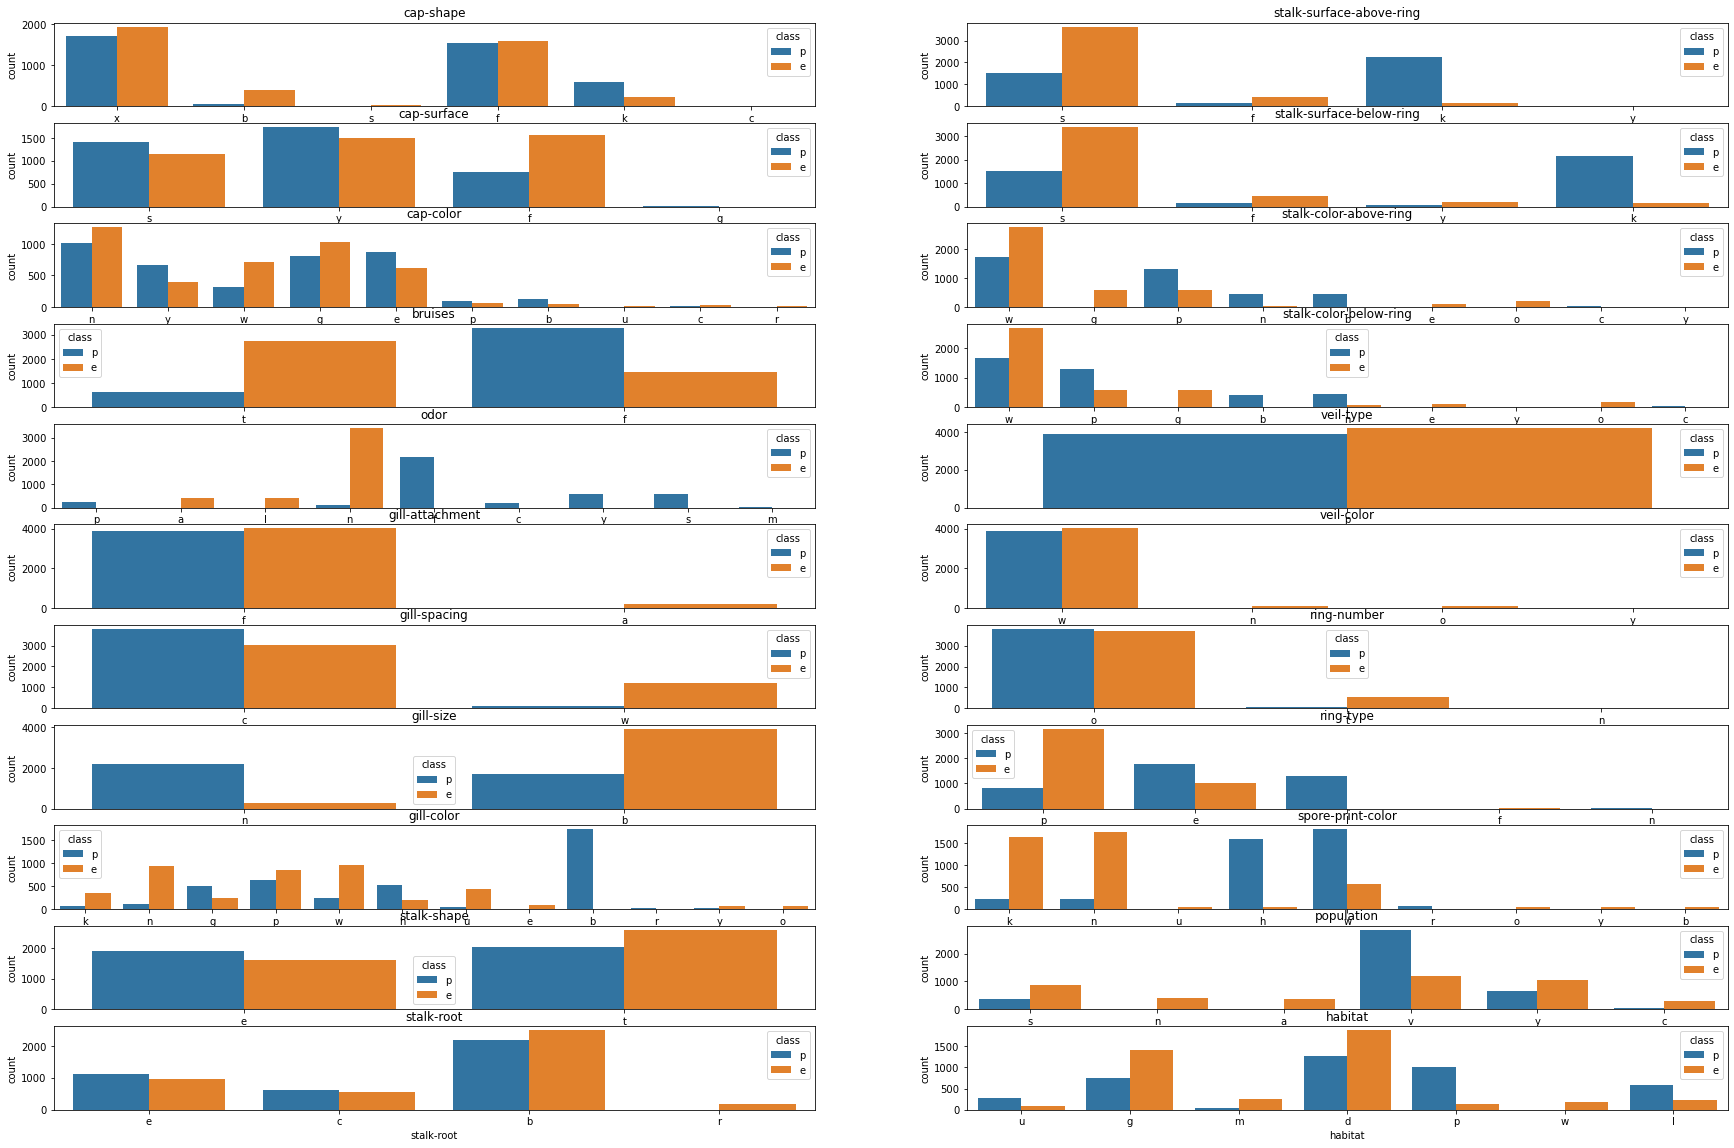

In [158]:
fig, axs= plt.subplots(ncols=2,nrows=11,figsize=(30,20))
axs = axs.T.flatten()

for i in range(len(to_plot)):
    
    sns.countplot(data=df,x=to_plot[i],hue='class',ax=axs[i])
    axs[i].set_title(to_plot[i])

The above exploration is indicative that some labels for odor, bruises and spore- print color seem to have good distinction between poisonous and edible while other dimensions like veil type and stalk shape have equal distribution of edible and poisonous among its labels.

## 4. Training and Evaluation

In [162]:
#Define Input and target variables
X=df[df.drop(columns='class').columns]
y=df['class']
#One hot Encode X
X=pd.get_dummies(X)
l_enc=LabelEncoder()
y=l_enc.fit_transform(y)

for the traiing there is no need for an imposed ordinality therefore one hot encoding the input variables makes most sense.

In [163]:
#Train Test Split
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=42)

### 4.1 Logistic Regression

Instead of manually tuning hyperparamters for the algorithm employing grid search exhaustively iterates over all combinations and returns the best one. Additionally cross validation is performed a specified number of times for the given set of hyper parameters.

In [164]:
#Parameter combinations based on docs
clf_params={'C':[0.001,0.01,0.1,1,10,100,1000],
            'penalty':['l1', 'l2'],
            'solver':['liblinear','saga','lbfgs']
           }

In [165]:
clf_model=GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=clf_params,
    cv=10,
    scoring='f1'
)
#f1 used for scoring because classification task

In [166]:
#Fitting step
clf_model.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this trai

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga', 'lbfgs']},
             scoring='f1')

The fit failed warnings are due to lbfgs combining with an l1 penalty, both parameters are needed therefore kept because they combine well with other parameters.

In [167]:
#The best logistic regression model based on cross validation of training data
clf_model.best_params_

{'C': 10, 'penalty': 'l1', 'solver': 'saga'}

In [170]:
#Prediction step
y_pred=clf_model.predict(X_test)

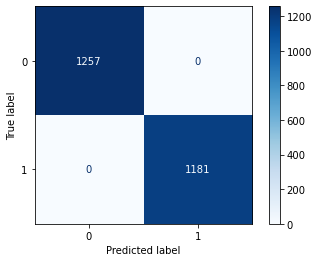

In [186]:
#Plot Confusion Matrix
metrics.plot_confusion_matrix(clf_model,X_test,y_test,cmap='Blues')

Seems the Algorithm performs well on the test set.

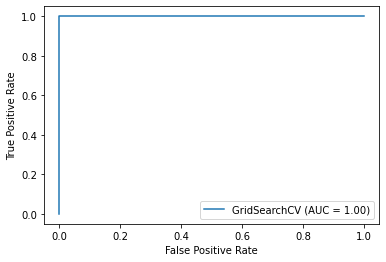

In [177]:
#Plot ROC
metrics.plot_roc_curve(clf_model,X_test,y_test)

In [188]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



<b> For comparison, is a Logistic regression Classifier with no hyperparamter tuning or cross- validation

In [193]:
#Train and predict
clf=LogisticRegression()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

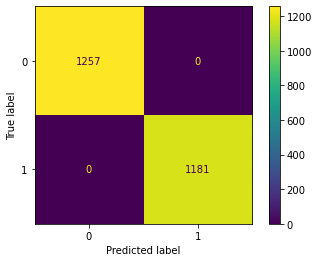

In [194]:
metrics.plot_confusion_matrix(clf,X_test,y_test)

Works just as well with regular logistic regression.

This is likely due to the visible differences in output classes that were observed in the previous section.

### 4.2 K Nearest Neighbors

In [179]:
#Parameters based on docs
knn_params={
    'n_neighbors':[3,5,7,9,11,17],
    'weights':['uniform','distance'],
    'metric':['minkowski','euclidean','manhattan']
}

In [180]:
knn_model=GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    cv=10,
    scoring='f1'
)

In [181]:
#Fitting step
knn_model.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 17],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [182]:
knn_model.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [184]:
knn_model.best_params_

{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}

In [189]:
#Prediction step
y_pred=knn_model.predict(X_test)

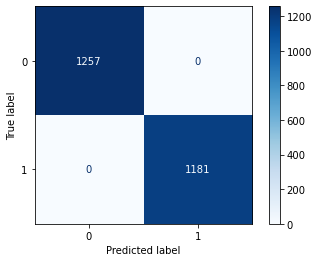

In [190]:
#Plot Confusion Matrix
metrics.plot_confusion_matrix(knn_model,X_test,y_test,cmap='Blues')

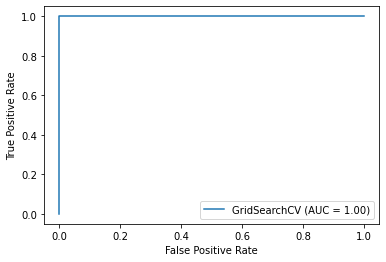

In [191]:
#Plot ROC
metrics.plot_roc_curve(knn_model,X_test,y_test)

In [192]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1257
           1       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



### 4.3 Decision Tree

In [197]:
#Hyperparameters from Doc
tree_params={
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_features':[None,'auto','log2'],
}

In [198]:
tree_model=GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=tree_params,
    cv=10,
    scoring='f1'
)

In [200]:
#Fit and predict
tree_model.fit(X_train,y_train)
y_pred=tree_model.predict(X_test)

In [210]:
tree_model.best_estimator_

DecisionTreeClassifier(max_features='auto')

In [211]:
tree_model.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'splitter': 'best'}

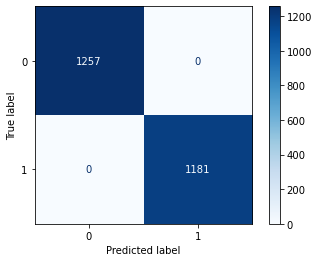

In [212]:
#Plot Confusion Matrix
metrics.plot_confusion_matrix(tree_model,X_test,y_test,cmap='Blues')

Not plotting ROC and report since these are identical

### 4.4 SVM

In [213]:
#Parameters from Doc
svm_params={
    'C':[0.001,0.01,0.1,1,10,100,1000],
    'kernel':['linear','poly','rbf','sigmoid'],
    'gamma':['scale','auto'],
}

In [214]:
svm_model=GridSearchCV(
    estimator=SVC(),
    param_grid=svm_params,
    cv=10,
    scoring='f1'
)

In [215]:
#Fit and predict
svm_model.fit(X_train,y_train)
y_pred=svm_model.predict(X_test)

In [216]:
svm_model.best_estimator_

SVC(C=1, kernel='linear')

In [217]:
svm_model.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

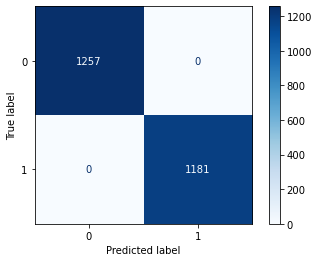

In [218]:
#Plot Confusion Matrix
metrics.plot_confusion_matrix(svm_model,X_test,y_test,cmap='Blues')

### 4.5 Random Forest

In [220]:
#Based on documentation
rfc_params = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [223]:
rfc_model=GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rfc_params,
    cv=4,
    scoring='f1'
)

In [224]:
#Fit and predict
rfc_model.fit(X_train,y_train)
y_pred=rfc_model.predict(X_test)

In [225]:
rfc_model.best_estimator_

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [226]:
rfc_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

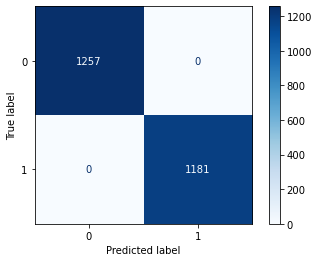

In [227]:
#Plot Confusion Matrix
metrics.plot_confusion_matrix(rfc_model,X_test,y_test,cmap='Blues')

### 4.6 Feed Forward Neural Network

In [233]:
#Create ANN with single layer and binary output
ann=Sequential()
ann.add(Dense(16,activation='relu'))
ann.add(Dense(1,activation='sigmoid'))
ann.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

ann.fit(X_train,y_train,batch_size=32,epochs=10)

Epoch 1/10
178/178 [==============================] - 0s 751us/step - loss: 0.2665 - accuracy: 0.9128
Epoch 2/10
178/178 [==============================] - 0s 723us/step - loss: 0.0642 - accuracy: 0.9887
Epoch 3/10
178/178 [==============================] - 0s 678us/step - loss: 0.0297 - accuracy: 0.9965
Epoch 4/10
178/178 [==============================] - 0s 717us/step - loss: 0.0168 - accuracy: 0.9988
Epoch 5/10
178/178 [==============================] - 0s 684us/step - loss: 0.0106 - accuracy: 0.9993
Epoch 6/10
178/178 [==============================] - 0s 706us/step - loss: 0.0072 - accuracy: 0.9995
Epoch 7/10
178/178 [==============================] - 0s 672us/step - loss: 0.0051 - accuracy: 0.9996
Epoch 8/10
178/178 [==============================] - 0s 728us/step - loss: 0.0038 - accuracy: 0.9996
Epoch 9/10
178/178 [==============================] - 0s 689us/step - loss: 0.0029 - accuracy: 0.9998
Epoch 10/10
178/178 [==============================] - 0s 695us/step - loss: 0.002

In [234]:
#prediction step
y_pred=ann.predict(X_test)

In [240]:
#Confusion matrix
metrics.confusion_matrix(y_test,y_pred.round())

array([[1257,    0],
       [   0, 1181]], dtype=int64)

## 5. Insights

From the results obtained, below are some of the most contributing features to classification negatively and positively.

In [249]:
features=pd.DataFrame(clf.coef_.T,index=X.columns.to_list(),columns=['Parameters'])

In [251]:
features.sort_values('Parameters',ascending=False).head()

,Parameters
spore-print-color_r,3.823212
odor_f,2.912688
odor_c,2.773887
gill-size_n,2.255038
odor_p,2.091316


Biggest postiive coefficients for logistic regression were the above, this means presence of spore print color red, creosote foul and/ or pungent oder and narrow gill size all strong indicators for class one. Based on the encoding class 1= 'p'. Therefore these are strong indicators of poisonous mushrooms. 

In [255]:
features.sort_values('Parameters').head()

,Parameters
odor_n,-4.079459
odor_a,-2.927630
odor_l,-2.891345
gill-size_b,-2.255106
ring-type_f,-1.682506


Applying the converse logic to the above statement mushrooms with neutral, almond and/ or anise odor, with broad gills and flaring ring type are edible.

<b> Visualizing the Results </b>

<AxesSubplot:xlabel='class', ylabel='count'>

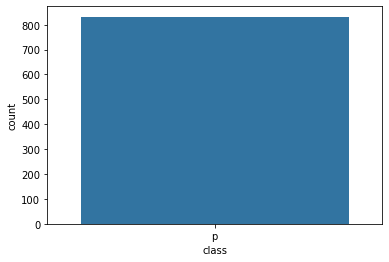

In [266]:
filtered=df[
    ((df['odor']=='r')|(df['odor']=='f')|(df['odor']=='p'))&
    (df['gill-size']=='n')
]
sns.countplot(data=filtered,x='class')

<AxesSubplot:xlabel='class', ylabel='count'>

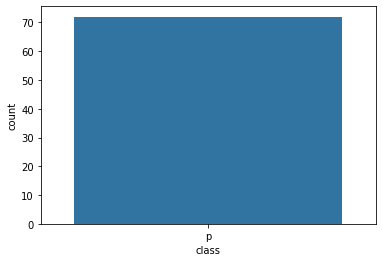

In [267]:
sns.countplot(data=df[df['spore-print-color']=='r'],x='class')

As expected these are all poisonous.

<AxesSubplot:xlabel='class', ylabel='count'>

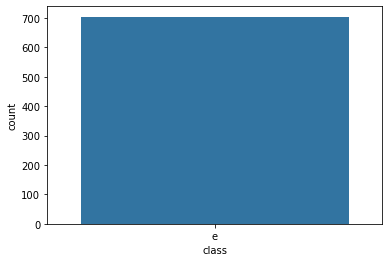

In [268]:
filtered=df[
    ((df['odor']=='a')|(df['odor']=='l')|(df['odor']=='c'))&
    (df['gill-size']=='b')
]
sns.countplot(data=filtered,x='class')

<AxesSubplot:xlabel='class', ylabel='count'>

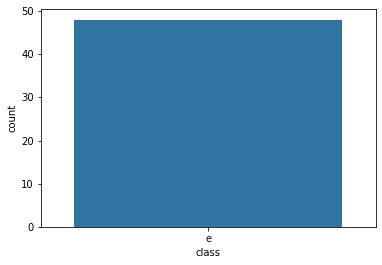

In [269]:
sns.countplot(data=df[df['ring-type']=='f'],x='class')